In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import random
import torch
import time
import makemore

In [3]:
def random_digit():
    return random.choice("123456789")

In [4]:
def palindrome():
    start_letters = [random_digit() for _ in range(5)]
    end_letters = list(reversed(start_letters))
    return "".join(start_letters + end_letters)
palindrome()

'8619449168'

In [5]:
train_dataset, test_dataset = makemore.generate_datasets(palindrome)

number of examples in the dataset: 100000
max word length: 10
number of unique characters in the vocabulary: 9
vocabulary:
123456789
split up the dataset into 99000 training examples and 1000 test examples


In [6]:
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
print(f"dataset determined that: {vocab_size=}, {block_size=}")

config = makemore.ModelConfig(vocab_size=vocab_size, block_size=block_size, n_layer=1, n_head=1, n_embd=7)
model = makemore.Transformer(config)
model.to("cuda")
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
learning_rate = 5e-4
weight_decay = 0.01
batch_size = 32
num_workers = 4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay,
                              betas=(0.9, 0.99), eps=1e-8)
batch_loader = makemore.InfiniteDataLoader(train_dataset, batch_size=batch_size, pin_memory=True,
                                           num_workers=num_workers)


dataset determined that: vocab_size=10, block_size=11
number of parameters: 0.00M
model #params: 910


In [7]:
n_steps = 10000
for step in range(n_steps):
    t0 = time.time()

    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to("cuda") for t in batch]
    X, Y = batch

    # feed into the model
    logits, loss = model(X, Y)

    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for all CUDA work on the GPU to finish then calculate iteration time taken
    torch.cuda.synchronize()
    t1 = time.time()

    # logging
    if step % (n_steps // 20) == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

# evaluate the model
train_loss = makemore.evaluate(model, train_dataset, batch_size=100, max_batches=10)
test_loss = makemore.evaluate(model, test_dataset, batch_size=100, max_batches=10)           
print(f"step {step} train loss: {train_loss} test loss: {test_loss}")
                
# sample from the model
makemore.print_samples(model, train_dataset, test_dataset, num=10)


step 0 | loss 2.4833 | step time 70.31ms
step 500 | loss 2.0672 | step time 1.26ms
step 1000 | loss 1.9530 | step time 1.19ms
step 1500 | loss 1.9085 | step time 1.27ms
step 2000 | loss 1.8448 | step time 1.23ms
step 2500 | loss 1.7996 | step time 1.45ms
step 3000 | loss 1.7400 | step time 1.38ms
step 3500 | loss 1.6324 | step time 1.17ms
step 4000 | loss 1.5563 | step time 1.21ms
step 4500 | loss 1.5261 | step time 1.18ms
step 5000 | loss 1.3824 | step time 1.34ms
step 5500 | loss 1.2096 | step time 1.18ms
step 6000 | loss 1.1119 | step time 1.15ms
step 6500 | loss 1.0494 | step time 1.19ms
step 7000 | loss 1.0258 | step time 1.19ms
step 7500 | loss 1.0050 | step time 1.44ms
step 8000 | loss 1.0060 | step time 1.26ms
step 8500 | loss 1.0064 | step time 1.13ms
step 9000 | loss 1.0074 | step time 1.17ms
step 9500 | loss 1.0076 | step time 1.18ms
step 9999 train loss: 1.0010218620300293 test loss: 1.0009135007858276
------------------------------------------------------------------------

model input: tensor([[0]], device='cuda:0')
first layer norm output:


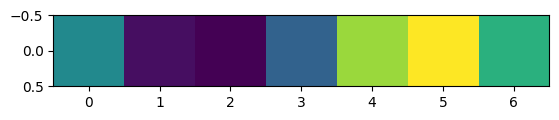

attention:


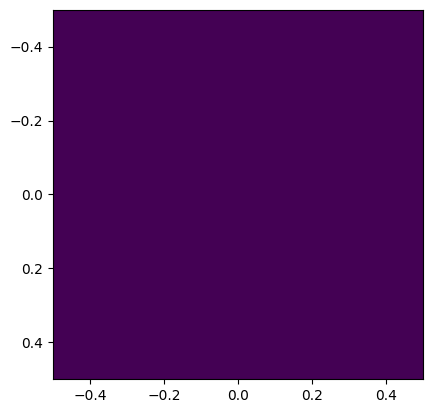

keys:


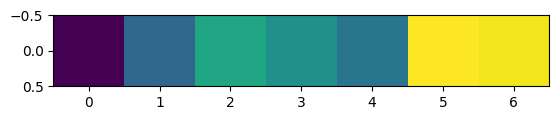

queries:


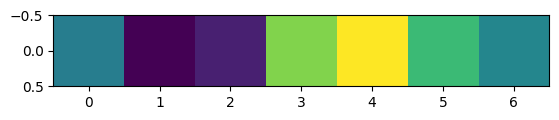

model input: tensor([[0, 4]], device='cuda:0')
first layer norm output:


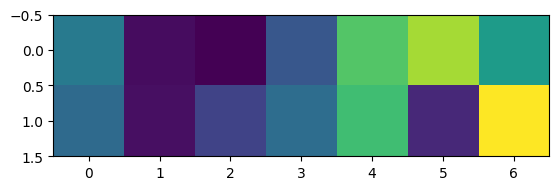

attention:


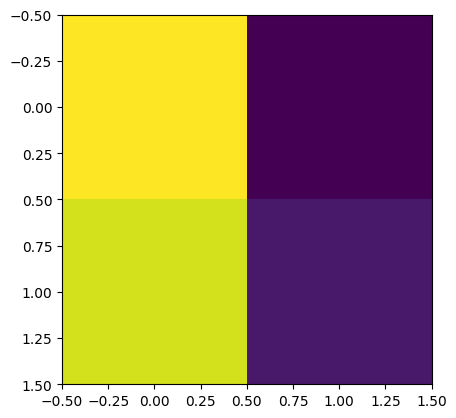

keys:


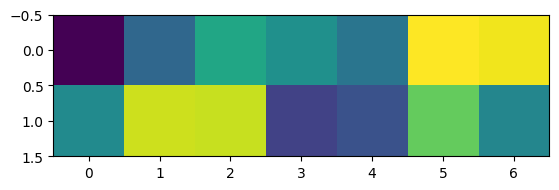

queries:


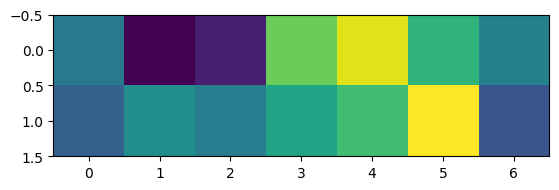

model input: tensor([[0, 4, 9]], device='cuda:0')
first layer norm output:


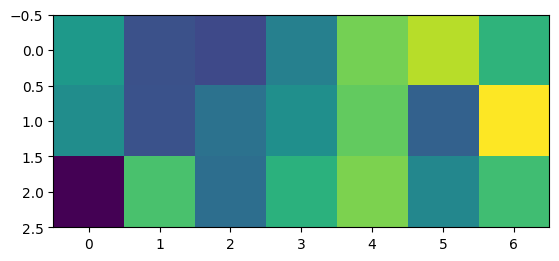

attention:


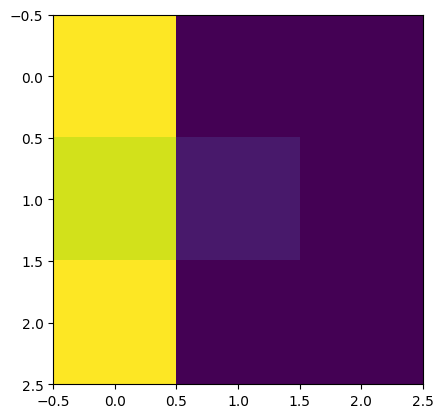

keys:


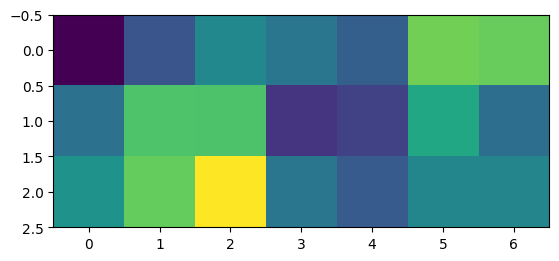

queries:


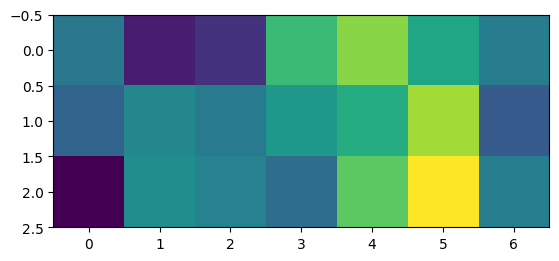

model input: tensor([[0, 4, 9, 9]], device='cuda:0')
first layer norm output:


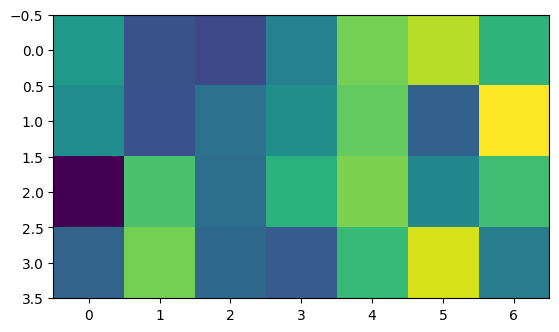

attention:


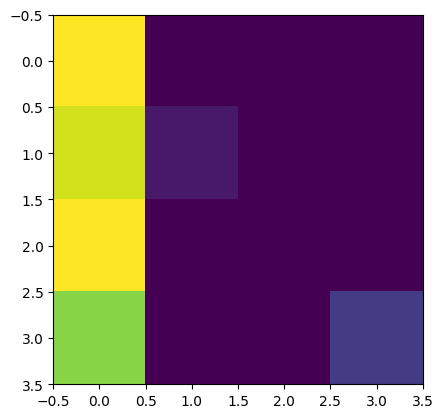

keys:


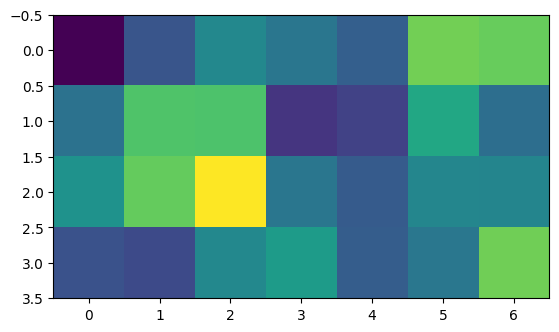

queries:


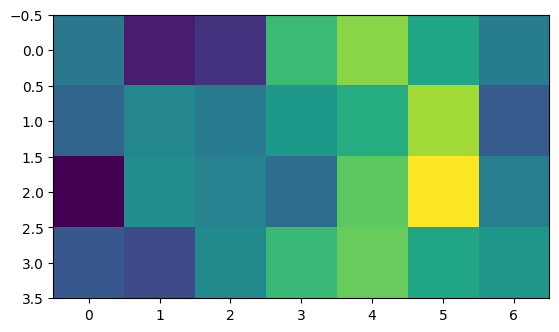

model input: tensor([[0, 4, 9, 9, 4]], device='cuda:0')
first layer norm output:


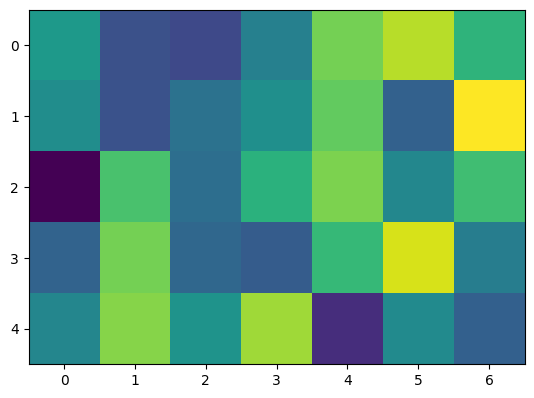

attention:


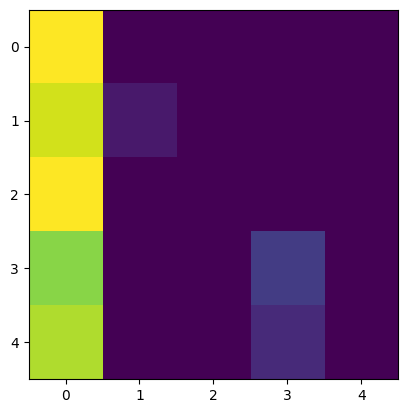

keys:


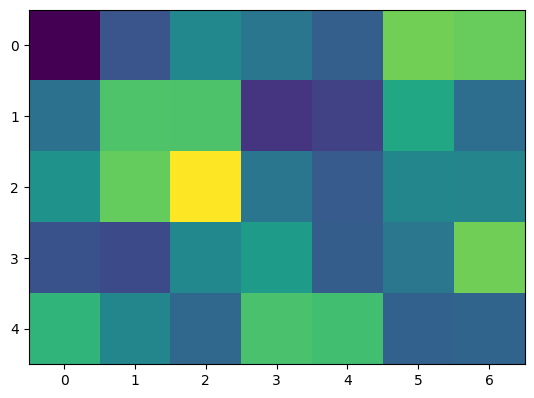

queries:


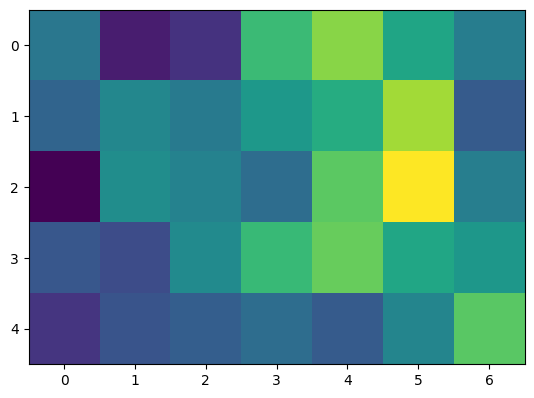

model input: tensor([[0, 4, 9, 9, 4, 4]], device='cuda:0')
first layer norm output:


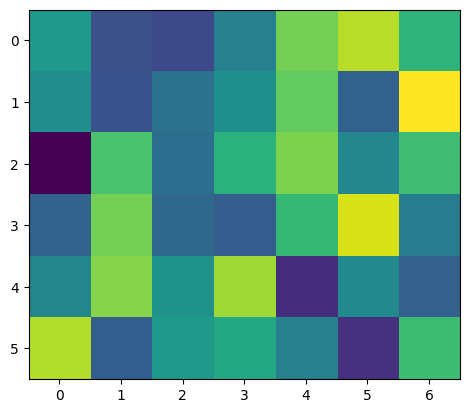

attention:


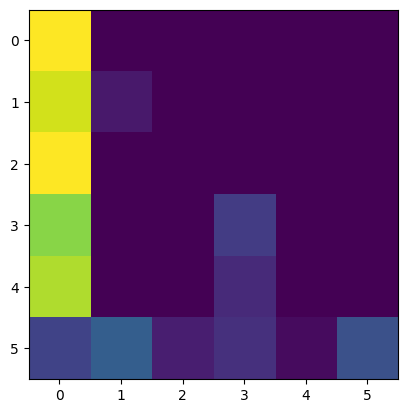

keys:


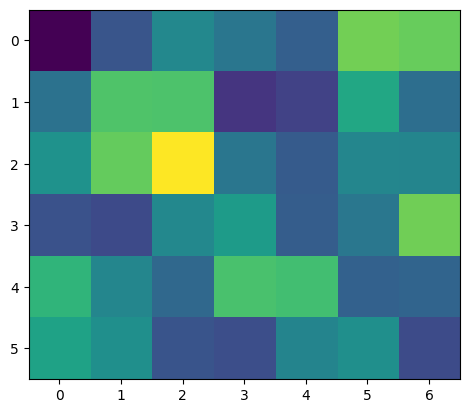

queries:


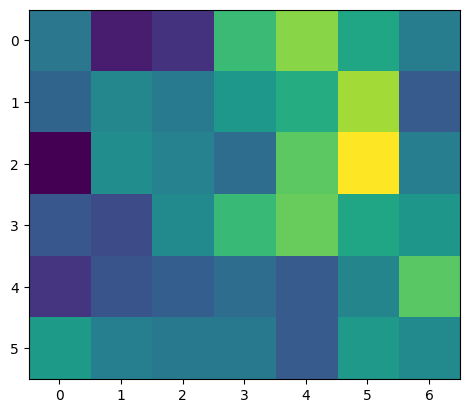

model input: tensor([[0, 4, 9, 9, 4, 4, 4]], device='cuda:0')
first layer norm output:


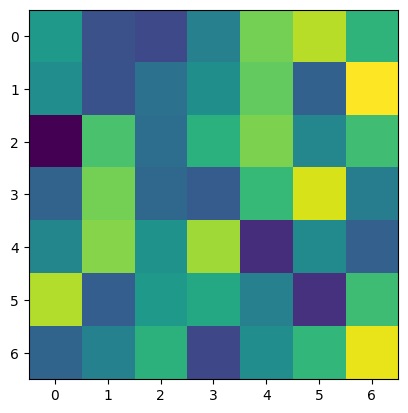

attention:


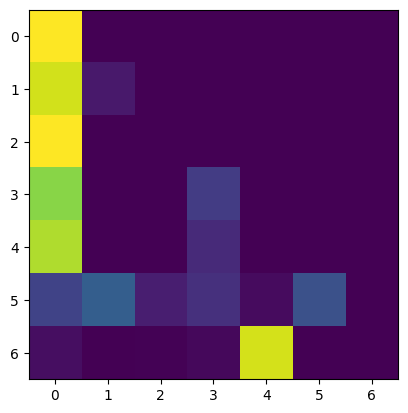

keys:


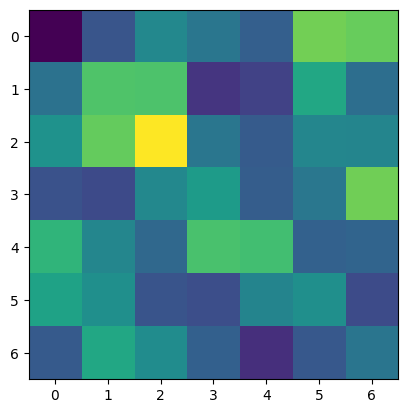

queries:


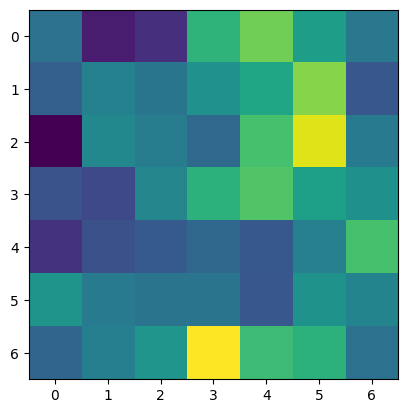

model input: tensor([[0, 4, 9, 9, 4, 4, 4, 4]], device='cuda:0')
first layer norm output:


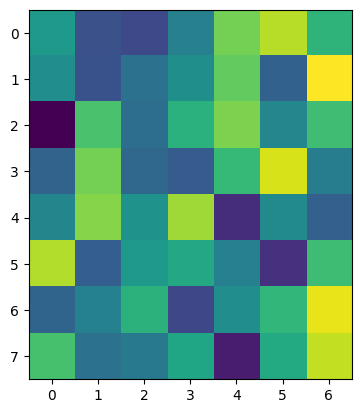

attention:


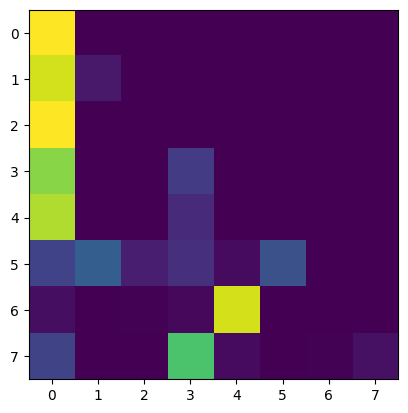

keys:


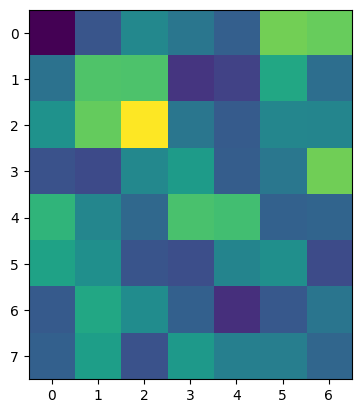

queries:


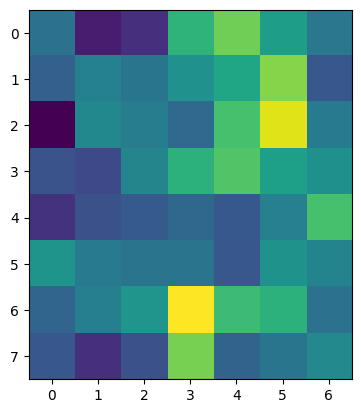

model input: tensor([[0, 4, 9, 9, 4, 4, 4, 4, 9]], device='cuda:0')
first layer norm output:


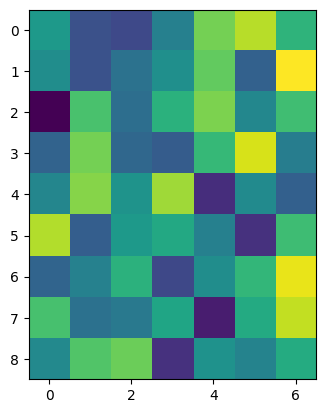

attention:


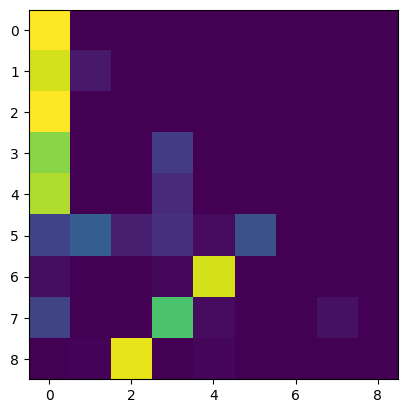

keys:


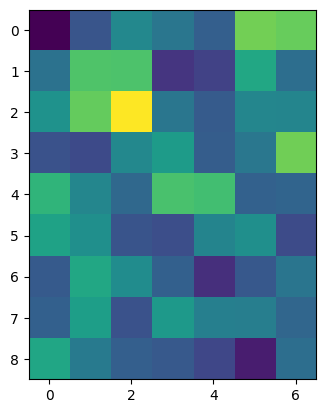

queries:


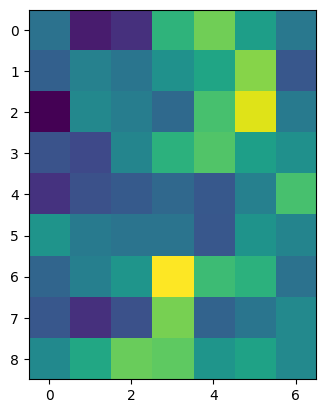

model input: tensor([[0, 4, 9, 9, 4, 4, 4, 4, 9, 9]], device='cuda:0')
first layer norm output:


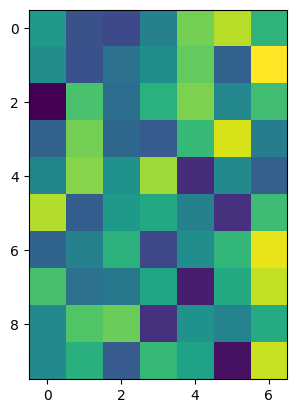

attention:


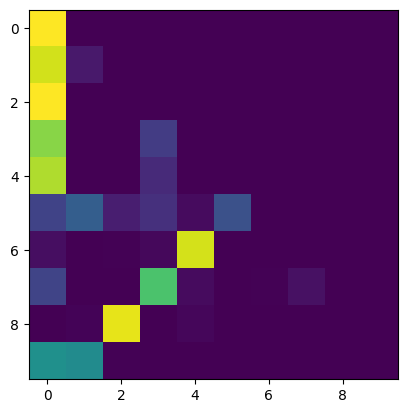

keys:


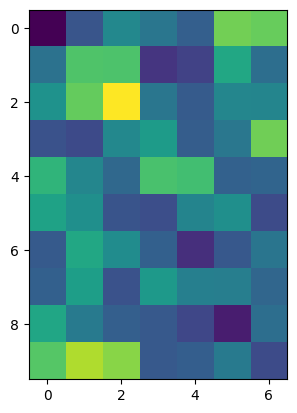

queries:


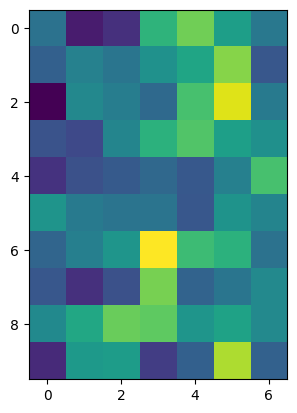

--------------------------------------------------------------------------------
1 samples that are in train:
4994444994
0 samples that are in test:
0 samples that are new:
--------------------------------------------------------------------------------


In [28]:
makemore.print_samples(model, train_dataset, test_dataset, num=1)

In [27]:
model.transformer

ModuleDict(
  (wte): Embedding(10, 7)
  (wpe): Embedding(11, 7)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=7, out_features=21, bias=True)
        (c_proj): Linear(in_features=7, out_features=7, bias=True)
      )
      (ln_2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
      (mlp): ModuleDict(
        (c_fc): Linear(in_features=7, out_features=28, bias=True)
        (c_proj): Linear(in_features=28, out_features=7, bias=True)
        (act): NewGELU()
      )
    )
  )
  (ln_f): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
)